In [4]:
using PyCall
using ProfileView
using Polynomials

In [5]:
tolerance = 1e-6
maxiter = 100

100

In [6]:
function newton_find_root(p :: Poly{Float64}, p_der :: Poly{Float64}, point :: Complex{Float64})
    val ::Complex{Float64} = polyval(p, point)
    niter :: Int = 0
    while abs(real(val^2)) > tolerance && niter < maxiter
        point = point - val / polyval(p_der, point)
        val = polyval(p, point)
        niter += 1
    end
    return round(point, 2), niter
end

newton_find_root (generic function with 1 method)

In [57]:
function plot_for(p :: Poly{Float64}; min_x = -5., max_x = 5., steps=100)
    der = polyder(p)
    r = roots(p)

    total = steps*steps
    dot_each = total / 100
    Xs = linspace(min_x, max_x, steps)
    res = SharedArray(Float64, (steps, steps, 2))
    iter = 0
    max = steps-2
    for i in 1:max
        for j in 1:max
            zero, iters = newton_find_root(p, der, Xs[i] +  1.im * Xs[j])
            zero_index = indmin(abs((r-zero)))
            res[j,i,1] = zero_index
            res[j,i,2] = iters
            iter += 1
            if iter % dot_each == 0
                print(".")
            end
        end
    end

    return Xs, Xs, res
end

plot_for (generic function with 1 method)

In [58]:
p = Poly([1.,0.,0.,10.,2.])

Poly(1.0 + 10.0x^3 + 2.0x^4)

In [59]:
@time res = plot_for(p, steps=1000)
""

..................................................................................................

""

.  5.582341 seconds (53.58 M allocations: 1.231 GB, 3.30% gc time)


In [7]:
Profile.clear()
@profile plot_for(p, steps=200)
""

6.894492 seconds (55.40 M allocations: 1.309 GB, 2.39% gc time)
....................................................

""

..............................................

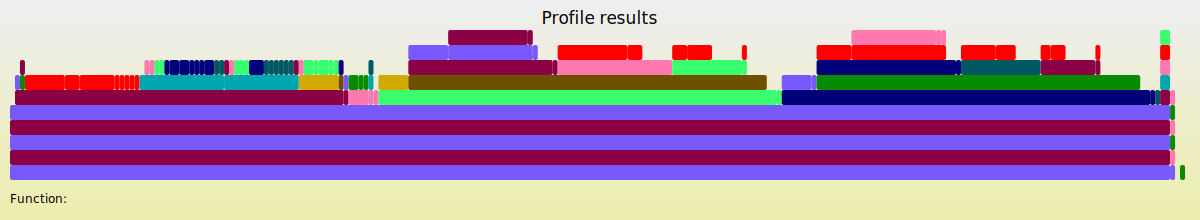

In [8]:
ProfileView.view()

In [10]:
using Images, Colors, FixedPointNumbers, ImageView

  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/luki/.julia/v0.4/ImageView/src/annotations.jl:61
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/luki/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/luki/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/luki/.julia/v0.4/ImageView/src/annotations.jl, in expression starting on line 96
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/luki/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/luki/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at 

In [47]:
function add_alpha(c, alpha)
    a = round(UInt8, 255 - 200*alpha)
    r = round(UInt8, c[1])
    g = round(UInt8, c[2])
    b = round(UInt8, c[3])
    return RGBA{U8}(r,g,b,a)
end

function plot_with_pil(arg; width=150, additional_alpha=0.1)
    Xs, Ys, res = arg
    min_x = Xs[1]
    max_x = reverse(Xs)[1]
    width_x = max_x - min_x
    
    point_to_plot(p) = round(Int, 1+width*(p-min_x)/width_x)
    x_y_to_plot(x,y) = (point_to_plot(x), point_to_plot(y))
    unit_width = abs(point_to_plot(Xs[1]) - point_to_plot(Xs[2]))
    
    colors = [(0., 0., 1.),
              (0., 1., 0.),
              (1., 0., 0.),
              (1., 0., 1.),
              (0., 1., 1.),
              (1., 1., 0.),
              (1., 0.5, 0.),
              (0., 0.5, 1.),
              (0.5, 1., 0.)]
    
    iters = res[:,:,2][:]
    max_iters = iters[indmax(iters)]
    min_iters = iters[indmin(iters)]
    width_iters = max_iters - min_iters
    res_to_rgb(zero, iters) = add_alpha(colors[convert(Int, zero)+1], additional_alpha+(iters-min_iters)/width_iters)
    
    w, h = width, width
    
    img = Array{RGBA{UFixed8}}((w+1, h+1))
    
    total = length(Xs) * length(Ys)
    each_num = total / 100
    
    iter = 0

    for i in (1:length(Xs))
        for j in reverse(1:length(Ys))
            x,y = x_y_to_plot(Xs[i],Ys[j])
            c = res_to_rgb(res[j,i,1], res[j,i,2])
            img[x, y] = c
            
            iter += 1
            if iter % each_num == 0
                print(".")
            end
           # for tx in max(x-unit_width, 1):min(x+unit_width, w)
           #     for ty in max(y-unit_width, 1):min(y+unit_width, h)
           #         img[tx, ty] = c
           #     end
           # end
        end
    end

    # draw axis  
    for x in 1:w
        img[x, div(h,2)] = RGBA{UFixed8}(1.,1.,1.,1.)
    end
    for y in 1:h
        img[div(w,2), y] = RGBA{UFixed8}(1.,1.,1.,1.)
    end
    
    Image(img)
end

plot_with_pil (generic function with 1 method)

.........................................................................................

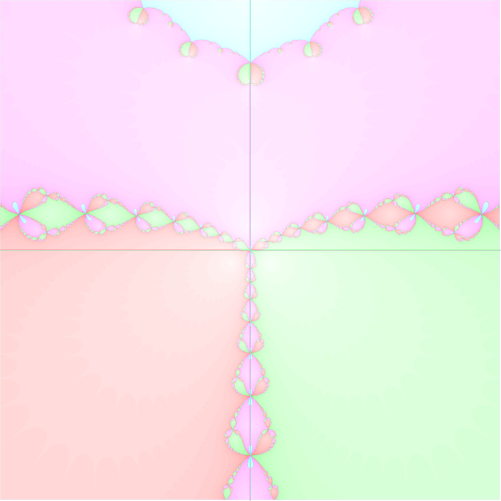

...........

In [52]:
i = plot_with_pil(res, width=1000, additional_alpha=0)

In [78]:
function plot_and_save(file, min_x, max_x)
    println("\n", file)
    println("Calculating..")
    res = plot_for(p, steps=1000, min_x = min_x, max_x = max_x)
    println("\nPlotting..")
    i = plot_with_pil(res, width=1000, additional_alpha=0)
    save(file, i)
    println("\nDone.")
end

plot_and_save (generic function with 2 methods)

In [79]:
plot_and_save("test.png", -5, 5)


test.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.


In [88]:
for x in linspace(10, 0, 100)
    plot_and_save((@sprintf "test_%f.png" x), -1.0 * x, x)
end


test_10.000000.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

test_9.898990.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

test_9.797980.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
Done.

test_9.696970.png
Calculating..
...................................................................................................
Plotting..
....................................................................................................
D

LoadError: LoadError: InexactError()
while loading In[88], in expression starting on line 1


Plotting..
